In [1]:
import pip
# pip.main(['install', '{insert_pckg_here}'])
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

## Loading Training/Testing Data:

In [2]:
train_url = 'https://raw.githubusercontent.com/mturner49/pylovers-final-project/dev/data/train.csv'
test_url = 'https://raw.githubusercontent.com/mturner49/pylovers-final-project/dev/data/test.csv'

training_set = pd.read_csv(train_url, low_memory=False, error_bad_lines=False, index_col='Id')
testing_set = pd.read_csv(test_url, low_memory=False, error_bad_lines=False, index_col='Id')

train_df = pd.DataFrame(training_set)
test_df = pd.DataFrame(testing_set)

train_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
# replace null values in df w/ values that had most counts for each column
train_df = train_df.apply(lambda x: x.fillna(0) if x.dtype.kind in 'biufc' \
                          else x.fillna(train_df.columns.value_counts().idxmax()))
test_df = test_df.apply(lambda x: x.fillna(0) if x.dtype.kind in 'biufc' \
                          else x.fillna(train_df.columns.value_counts().idxmax()))
# combining the training and test dfs
# dfs = [train_df, test_df]
# df = pd.concat(dfs)

# df.head()

## Data Exploration:

In [4]:
#print(train_df.MSZoning)

#df = train_df.groupby('MSZoning').size()
#print (df)

# Converting category labels to numerical values for MSZoning column
train_df['MSZoning_Num'] = train_df.MSZoning.map(
{'C (all)': 1,
 'FV': 2,
 'RH': 3,
 'RL': 4,
 'RM': 5})

#print(train_df.MSZoning_Num)

In [5]:
#print(train_df.LotConfig)

#df = train_df.groupby('LotConfig').size()
#print (df)

# Converting category labels to numerical values for LotConfig column
train_df['LotConfig_Num'] = train_df.LotConfig.map(
{'Corner': 1,
 'CulDSac': 2,
 'FR2': 3,
 'FR3': 4,
 'Inside': 5})

#print(train_df.LotConfig_Num)    

In [6]:
#print(train_df.Neighborhood)

#df = train_df.groupby('Neighborhood').size()
#print (df)

# Converting category labels to numerical values for Neighborhood column
train_df['Neighborhood_Num'] = train_df.Neighborhood.map(
{'Blmngtn': 1,
 'Blueste': 2,
 'BrDale': 3,
 'BrkSide': 4,
 'ClearCr': 5,
 'CollgCr': 6,
 'Crawfor': 7,
 'Edwards': 8,
 'Gilbert': 9,
 'IDOTRR':  10,
 'MeadowV': 11,
 'Mitchel': 12,
 'NAmes': 13,
 'NPkVill': 14,
 'NWAmes': 15,
 'NoRidge': 16,
 'NridgHt': 17,
 'OldTown': 18,
 'SWISU': 19,
 'Sawyer': 20,
 'SawyerW': 21,
 'Somerst': 22,
 'StoneBr': 23,
 'Timber': 24,
 'Veenker': 25})

#print(train_df.Neighborhood_Num)

In [7]:
#print(train_df.KitchenQual)

#df = train_df.groupby('KitchenQual').size()
#print (df)

# Converting category labels to numerical values for KitchenQual column
train_df['KitchenQual_Num'] = train_df.KitchenQual.map(
{'Po':1, 
 'Fa':2, 
 'TA':3, 
 'Gd':4, 
 'Ex':5})

#print(train_df.KitchenQual_Num)

In [8]:
#print(train_df.SaleCondition)

#df = train_df.groupby('SaleCondition').size()
#print (df)

# Converting category labels to numerical values for SaleCondition column
train_df['SaleCondition_Num'] = train_df.SaleCondition.map(
{'Abnorml':1, 
 'AdjLand':2, 
 'Alloca':3, 
 'Family':4, 
 'Normal':5,
 'Partial':6})

#print(train_df.SaleCondition_Num)

In [9]:
#looking at correlation of numeric features to SalePrice column. 
#This might suggest which columns have a greater relationship with the SalePrice column 
corr = train_df.corr()['SalePrice']
print(corr)

MSSubClass          -0.084284
LotFrontage          0.209624
LotArea              0.263843
OverallQual          0.790982
OverallCond         -0.077856
YearBuilt            0.522897
YearRemodAdd         0.507101
MasVnrArea           0.472614
BsmtFinSF1           0.386420
BsmtFinSF2          -0.011378
BsmtUnfSF            0.214479
TotalBsmtSF          0.613581
1stFlrSF             0.605852
2ndFlrSF             0.319334
LowQualFinSF        -0.025606
GrLivArea            0.708624
BsmtFullBath         0.227122
BsmtHalfBath        -0.016844
FullBath             0.560664
HalfBath             0.284108
BedroomAbvGr         0.168213
KitchenAbvGr        -0.135907
TotRmsAbvGrd         0.533723
Fireplaces           0.466929
GarageYrBlt          0.261366
GarageCars           0.640409
GarageArea           0.623431
WoodDeckSF           0.324413
OpenPorchSF          0.315856
EnclosedPorch       -0.128578
3SsnPorch            0.044584
ScreenPorch          0.111447
PoolArea             0.092404
MiscVal   

## Data Visualization (CAN BE DELETED):

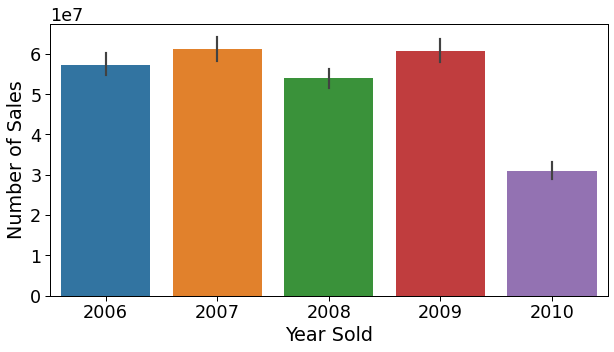

In [10]:
#Count the number of houses sold in a year
#year_sold_pivot = train_df.pivot_table(index='YrSold', values='SalePrice', aggfunc='count')
#print(year_sold_pivot)

# Plotting the sum of sales per year
sns.set_context("paper", font_scale=2) 
plt.figure(figsize=(10,5))
sns.barplot(x='YrSold', y='SalePrice', data=train_df[['SalePrice', 'YrSold']], estimator=sum)
plt.xlabel('Year Sold')
plt.ylabel('Number of Sales')
plt.show()

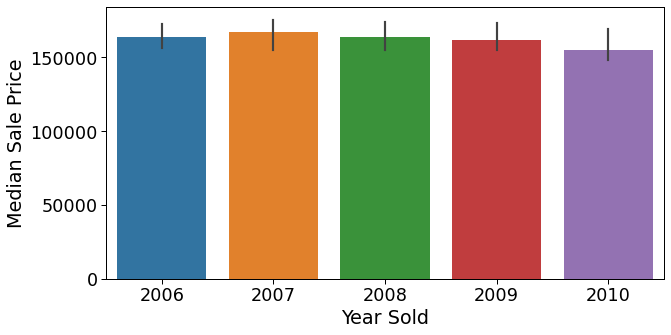

In [11]:
# Plotting the median sale price for each year

#Checking the median price
#year_sold_pivot = train_df.pivot_table(index='YrSold', values='SalePrice', aggfunc=np.median)
#print(year_sold_pivot)

sns.set_context("paper", font_scale=2) 
plt.figure(figsize=(10,5))
sns.barplot(x='YrSold', y='SalePrice', data=train_df[['SalePrice', 'YrSold']], estimator=np.median)
plt.xlabel('Year Sold')
plt.ylabel('Median Sale Price')
plt.show()

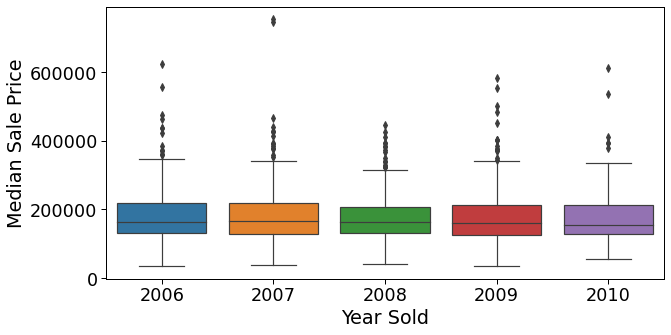

In [12]:
#Displaying the median price for each year using box plot.  
sns.set_context("paper", font_scale=2) 
plt.figure(figsize=(10,5))
sns.boxplot(x='YrSold', y='SalePrice', data=train_df[['SalePrice', 'YrSold']])
plt.xlabel('Year Sold')
plt.ylabel('Median Sale Price')
plt.show()

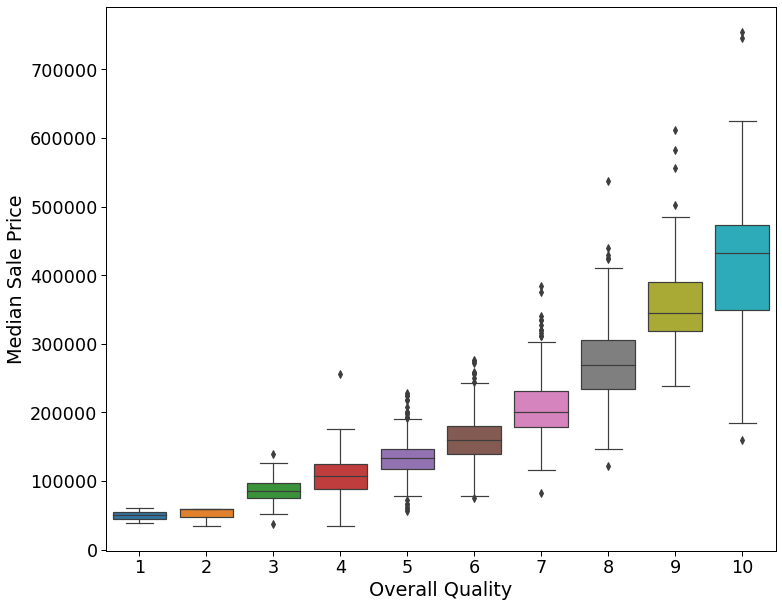

In [13]:
#Displaying the median price based on overall quality of the house using box plot.
sns.set_context("paper", font_scale=2) 
plt.figure(figsize=(12,10))
sns.boxplot(x='OverallQual', y='SalePrice', data=train_df[['SalePrice', 'OverallQual']])
plt.xlabel('Overall Quality')
plt.ylabel('Median Sale Price')
plt.show()

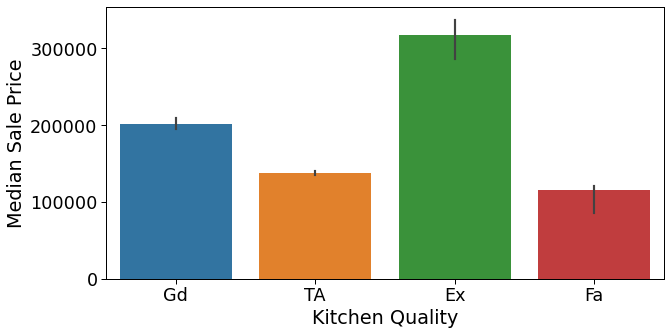

In [14]:
# Plotting the median sale price based on kitchen quality
sns.set_context("paper", font_scale=2) 
plt.figure(figsize=(10,5))
sns.barplot(x='KitchenQual', y='SalePrice', data=train_df[['SalePrice', 'KitchenQual']], estimator=np.median)
plt.xlabel('Kitchen Quality')
plt.ylabel('Median Sale Price')
plt.show()

## Feature Engineering:

In [15]:
# Ratio of Basement Quality ['BsmtQual'] to Overall Quality ['OverallQual']

In [16]:
# Ratio of Exterior Quality ['ExterQual'] to Overall Quality ['OverallQual']

In [17]:
# Ratio of Kitchen Quality ['KitchenQual'] to Overall Quality ['OverallQual']

In [18]:
################## DISREGARD LOGIC BELOW ######################

In [19]:
# encode object columns
# enc_df = train_df.select_dtypes(include=['object']).apply(LabelEncoder().fit_transform)
# enc_df

In [20]:
# add encoded columns back into train df
# train_df[enc_df.columns] = enc_df
# train_df

In [21]:
# normalize df except for price column
# norm_df = (train_df - train_df.mean()) / (train_df.max() - train_df.min())